# Random Forest

In [1]:
from IPython.display import display, Image, Latex, Markdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz

from six import StringIO
import pydotplus

from epl.query import create_and_query
from epl.match_utils import full_table_calculator, league_table_asof, result_calculator, table_calculator
from epl.feature_utils import add_game_week, add_league_pos, add_prev_season_pos, add_result_streak, add_avg_cols
from epl.model_utils import gen_sm_logit_preds, print_conf_mat, print_logit_params, sm_logit_output_explanation

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

In [4]:
try:
    df = pd.read_pickle('feature_df')
    streaks = [3, 5, 10, 20]
except:
    print('feature_df is not defined yet')

In [16]:
# id_data is data to help identify and group results
id_data = ['Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H' ,'B365D', 'B365A']
# pred col the col we are predicting
pred_col = 'FTR'
# features the cols we use to train the model
features = [x for x in df.columns if 'Adv' in x]

In [17]:
# create a new df with only the cols needed
df_est = df[id_data + [pred_col] + features].dropna()
# define x and y dataframes - will convert to np.array if required for sklearn (rather than sm)
y = df_est[pred_col]
X = df_est[features]

# print out df
df_est.tail()

,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,FTR,HAvgGF_3Adv,HAvgGF_5Adv,HAvgGF_10Adv,HAvgGF_20Adv,HAvgGA_3Adv,HAvgGA_5Adv,HAvgGA_10Adv,HAvgGA_20Adv,HAvgSF_3Adv,HAvgSF_5Adv,HAvgSF_10Adv,HAvgSF_20Adv,HAvgSA_3Adv,HAvgSA_5Adv,HAvgSA_10Adv,HAvgSA_20Adv,HAvgSTF_3Adv,HAvgSTF_5Adv,HAvgSTF_10Adv,HAvgSTF_20Adv,HAvgSTA_3Adv,HAvgSTA_5Adv,HAvgSTA_10Adv,HAvgSTA_20Adv,HAvgPPG_3Adv,HAvgPPG_5Adv,HAvgPPG_10Adv,HAvgPPG_20Adv,HPointsAdv,HLeagPosAdv,HPrevLeagPosAdv
6784,E0,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,1.85,3.8,4.00,A,0.000000,-0.2,0.8,0.35,0.333333,0.2,0.0,-0.15,-4.666667,0.0,1.5,1.35,3.666667,-0.2,-2.6,-3.30,-4.333333,-1.8,0.5,0.9,0.333333,0.2,-0.7,-1.20,0.666667,0.4,0.5,0.25,-4.0,8.0,-3.0
6786,E0,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,1.72,3.8,4.75,H,-0.666667,0.4,0.4,0.40,-1.666667,-1.2,-0.6,-0.55,2.000000,3.8,3.0,4.05,-9.333333,-8.2,-3.6,-4.50,1.666667,3.0,2.3,2.3,-4.333333,-3.4,-1.5,-1.25,0.666667,1.0,0.6,0.70,2.0,-3.0,-9.0
6782,E0,2020/2021,2020-10-04,Arsenal,Sheffield United,2.0,1.0,1.57,4.0,6.00,H,2.000000,1.6,1.0,0.90,0.000000,-0.2,-0.1,0.00,-1.000000,0.8,1.4,0.55,-2.000000,0.6,1.9,1.65,1.666667,1.4,1.7,1.3,-0.666667,0.2,0.8,0.75,2.000000,1.8,0.9,0.50,6.0,-10.0,-1.0
6783,E0,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,1.50,4.0,7.50,H,0.000000,0.4,0.2,0.30,-1.000000,-1.2,-0.8,-1.20,-1.000000,-1.8,-1.5,-0.65,1.000000,-2.2,-4.5,-5.80,-1.333333,-0.4,-0.5,-0.3,0.000000,-1.2,-2.2,-2.30,1.000000,1.2,0.4,1.00,3.0,-5.0,-13.0
6787,E0,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,1.61,4.2,5.25,A,2.333333,1.0,0.1,0.20,0.000000,0.6,0.4,-0.35,-3.333333,1.2,0.0,2.15,2.000000,-0.8,-2.5,-3.65,2.333333,2.4,0.9,0.8,1.333333,0.4,-0.2,-0.45,2.000000,0.8,0.1,0.30,6.0,-10.0,-11.0


In [18]:
test_frac = 1/10
seed = 123

# split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_frac, random_state=seed, stratify=y)

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(features)))

Using 5,236 cases for training
---
Using 582 cases for testing
---
Using following factors to predict: HAvgGF_3Adv, HAvgGF_5Adv, HAvgGF_10Adv, HAvgGF_20Adv, HAvgGA_3Adv, HAvgGA_5Adv, HAvgGA_10Adv, HAvgGA_20Adv, HAvgSF_3Adv, HAvgSF_5Adv, HAvgSF_10Adv, HAvgSF_20Adv, HAvgSA_3Adv, HAvgSA_5Adv, HAvgSA_10Adv, HAvgSA_20Adv, HAvgSTF_3Adv, HAvgSTF_5Adv, HAvgSTF_10Adv, HAvgSTF_20Adv, HAvgSTA_3Adv, HAvgSTA_5Adv, HAvgSTA_10Adv, HAvgSTA_20Adv, HAvgPPG_3Adv, HAvgPPG_5Adv, HAvgPPG_10Adv, HAvgPPG_20Adv, HPointsAdv, HLeagPosAdv, HPrevLeagPosAdv


In [26]:
clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=3, random_state=123, )

In [27]:
clf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=1000,
                       random_state=123)

In [28]:
y_pred = clf.predict(x_test)

In [29]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.5515463917525774


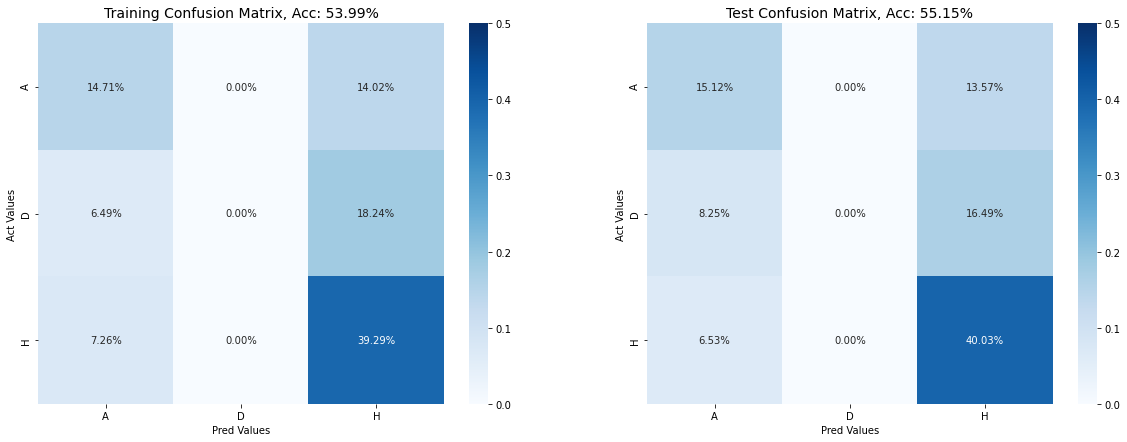

In [39]:
print_conf_mat(clf, y_test, x_test, lib='sklearn', x_train=x_train, y_train=y_train)

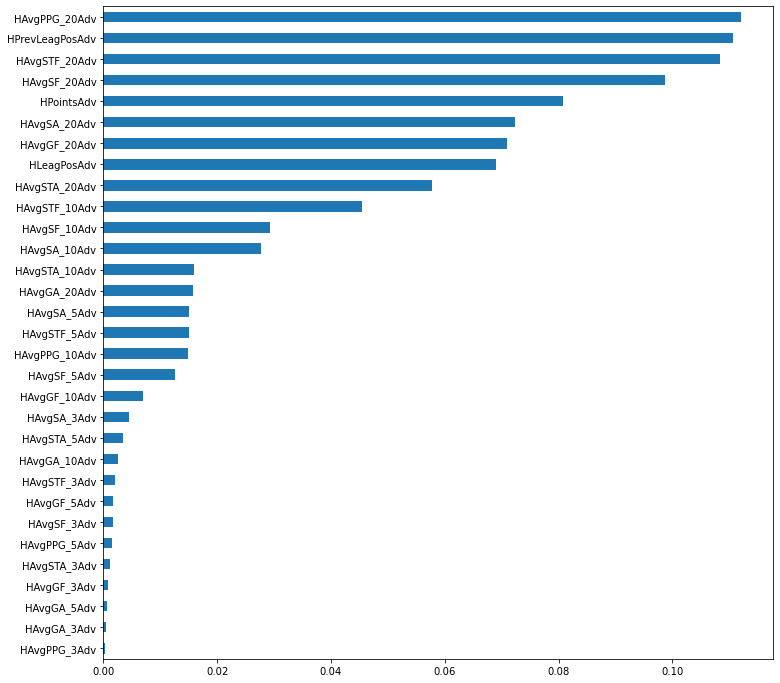

In [30]:
feature_importances = pd.Series(clf.feature_importances_, index = X.columns)
feature_importances = feature_importances.sort_values();
feature_importances.plot(kind='barh', figsize = (12,12));

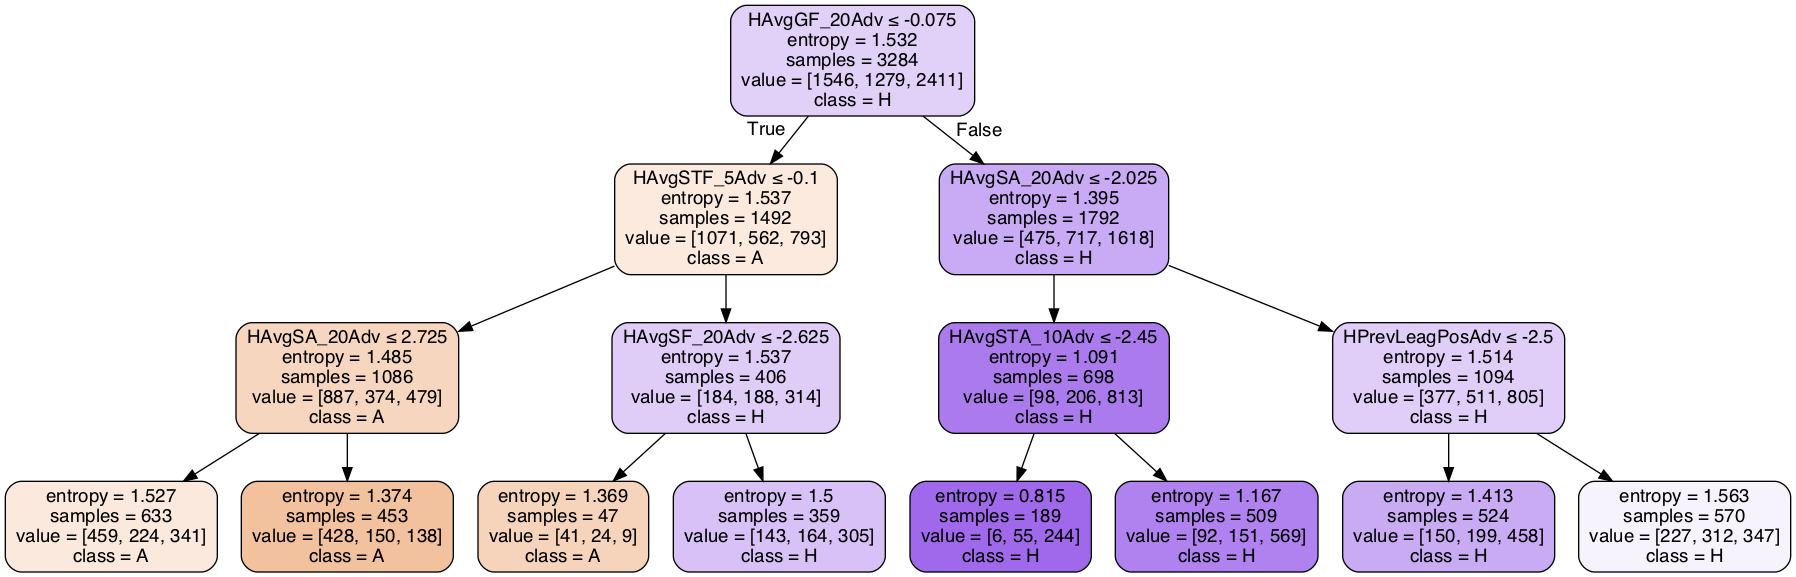

In [31]:
dot_data = StringIO()
estimator = clf.estimators_[45]
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=x_train.columns,class_names = ['A', 'D', 'H'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())